In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style('white')

from functions import *

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

with SequenceFile("data/uniprot-9606.fasta", digital=True, alphabet=alphabet) as seq_file:
    sequences = list(seq_file)
    

uniprot = fasta_reader('data/uniprot-9606.fasta')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
aa_known = 'ACDEFGHIKLMNPQRSTVWY'
prob_range = [0.9, 0.8, 0.6, 0.4, 0.2, 0.3, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05]
repeats = 10


lengths = [100, 50, 25, 15, 10, 5]


In [3]:
def combine_scores(query, all_dfs):
    try:
        temp_df = pd.concat([i[i.Query == query] for i in all_dfs]).reset_index(drop=True)
        summed = temp_df.groupby('Accession')['Score'].sum().sort_values(ascending=False)
        return summed.index[0]
    except Exception as exp:
        if temp_df.size == 0:
            return 'No hits for this accession (not found)'
        else:
            return str(exp)

In [4]:
def stats_accuracy(prob, length, repeats=10):
    
    all_dfs = []
    for r in range(repeats):

        fname = 'results/scan_results/' + f'{r}_frag_length_{length}_{aa_known}_max_prob_{prob}_del.pkl.gz'
        test_df = pd.read_pickle(fname)
        all_dfs.append(test_df)
    
    results0 = pd.DataFrame({'Query': uniprot.Accession})
    results0['Accession'] = results0['Query'].parallel_apply(lambda x: combine_scores(x, all_dfs))
    
    # accuracy
    acc = results0[results0['Query'] == results0['Accession']].shape[0]/results0.shape[0]
    del results0, all_dfs
    return acc
    

In [33]:
# pd.read_pickle('results/all_fragments_all_AA_no_indels.pkl.gz').head(2)

,known aa,max_prob,total queries,hits,identified,fragment#,identified_frac,Type
0,ACDEFGHIKLMNPQRSTVWY,0.9,20181,20178,19446,0,0.96358,100 AA
1,ACDEFGHIKLMNPQRSTVWY,0.8,20181,20179,19436,0,0.963084,100 AA


In [5]:
all_results = pd.DataFrame(columns=['known aa', 'max_prob', 'identified_frac', 'Type'])
all_results

,known aa,max_prob,identified_frac,Type


In [6]:
total_queries = uniprot.shape[0]

In [7]:
#### This takes a LOT of time!
aa_known = 'ACDEFGHIKLMNPQRSTVWY'
prob_range = [0.9, 0.8, 0.6, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05]
repeats = 10


lengths = [100, 50, 25, 15, 10, 5]

counter = 0
for prob in prob_range:
    for length in lengths:
        all_results.loc[counter] = [aa_known, prob, stats_accuracy(prob, length), f'{length} AA', ]
        counter += 1
        print(counter, end='\r')
#1:18:50

In [9]:
all_results.to_pickle('results/frag_combined_all_aa_no_indels.pkl.gz')

In [10]:
all_results = pd.read_pickle('results/frag_combined_all_aa_no_indels.pkl.gz')

In [11]:
frag_full_all_aa = pd.read_pickle('results/frag_and_full_len_all_aa_no_indels_.pkl.gz')

In [12]:
full_len = frag_full_all_aa[frag_full_all_aa['Type'] == 'Full length']
all_results1 = pd.concat([full_len[all_results.columns], all_results, ]).reset_index(drop=True)

In [13]:
groupedby = pd.DataFrame(frag_full_all_aa.groupby(['Type', 'max_prob', ])['identified_frac'].mean())
groupedby.query('max_prob == 0.2')

,,identified_frac
Type,max_prob,
10 AA,0.2,0.051291
100 AA,0.2,0.960359
15 AA,0.2,0.703880
25 AA,0.2,0.940880
5 AA,0.2,0.000213
50 AA,0.2,0.953090
Full length,0.2,0.983995


In [239]:
all_results1[all_results1['Type'] == '10 AA']

,known aa,max_prob,identified_frac,Type
15,ACDEFGHIKLMNPQRSTVWY,0.90,0.968485,10 AA
21,ACDEFGHIKLMNPQRSTVWY,0.80,0.969377,10 AA
27,ACDEFGHIKLMNPQRSTVWY,0.60,0.968237,10 AA
33,ACDEFGHIKLMNPQRSTVWY,0.40,0.966206,10 AA
39,ACDEFGHIKLMNPQRSTVWY,0.20,0.223081,10 AA
45,ACDEFGHIKLMNPQRSTVWY,0.10,0.0,10 AA
51,ACDEFGHIKLMNPQRSTVWY,0.09,0.0,10 AA
57,ACDEFGHIKLMNPQRSTVWY,0.08,0.0,10 AA
63,ACDEFGHIKLMNPQRSTVWY,0.07,0.0,10 AA
69,ACDEFGHIKLMNPQRSTVWY,0.06,0.0,10 AA


/homes/bikash/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


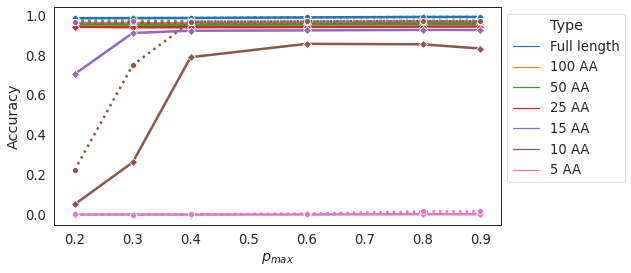

In [15]:
posts = [0.9, 0.8, 0.6, 0.4, 0.3, 0.2]
plt.figure(figsize=(8, 4))
# ax = sns.pointplot(data=frag_full_all_aa[frag_full_all_aa['max_prob'].apply(lambda x: x in posts)], \
#                      x='max_prob', y='identified_frac', hue='Type', \
#                   palette="Set1", markers=list('o^sP*XD'), scale=1.2)
ax = sns.lineplot(data=frag_full_all_aa[frag_full_all_aa['max_prob'].apply(lambda x: x in posts)], \
                     x='max_prob', y='identified_frac', hue='Type', \
                   marker='D', markersize=6, lw=2.5, err_style='bars', legend=None, \
                 )
ax = sns.lineplot(data=all_results1[all_results1['max_prob'].apply(lambda x: x in posts)], \
                     x='max_prob', y='identified_frac', hue='Type', \
                   marker='o', markersize=6, lw=2.5, linestyle=':')
ax.set_xlabel(r'${p_{max}}$')
ax.set_ylabel('Accuracy');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
plt.savefig('figs/fig2_with_combined_result.pdf', bbox_inches='tight');

In [30]:
tt = all_results1[all_results1['max_prob'].apply(lambda x: x in posts)]
tt[tt['Type'] == '10 AA']

,known aa,max_prob,identified_frac,Type
16,ACDEFGHIKLMNPQRSTVWY,0.9,0.968485,10 AA
22,ACDEFGHIKLMNPQRSTVWY,0.8,0.969377,10 AA
28,ACDEFGHIKLMNPQRSTVWY,0.6,0.968237,10 AA
34,ACDEFGHIKLMNPQRSTVWY,0.4,0.966206,10 AA
40,ACDEFGHIKLMNPQRSTVWY,0.3,0.74803,10 AA
46,ACDEFGHIKLMNPQRSTVWY,0.2,0.223081,10 AA


In [34]:
tt = frag_full_all_aa[frag_full_all_aa['max_prob'].apply(lambda x: x in posts)]
tt[(tt['Type'] == '10 AA') & (tt['max_prob'] == 0.3)]['identified_frac'].mean()

0.2618502551905257

In [35]:
0.262 - 0.748

-0.486

#####  100 fragments (5AA) for pmax = 0.9 

In [339]:
! ls -lht results/scan_results | grep frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz | head -n 10

-rw-r--r-- 1 bikash goldmans  5.3K Feb 12 02:40 999_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  4.6K Feb 12 02:30 998_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  5.1K Feb 12 02:20 997_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  5.1K Feb 12 02:11 996_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  5.2K Feb 12 02:01 995_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  5.3K Feb 12 01:51 994_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  4.9K Feb 12 01:41 993_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  4.1K Feb 12 01:32 992_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-rw-r--r-- 1 bikash goldmans  4.9K Feb 12 01:22 991_frag_length_5_ACDEFGHIKLMNPQRSTVWY_max_prob_0.9_del.pkl.gz
-

In [142]:
1000*4/60/24

2.777777777777778

In [94]:
# Uncomment and run this first time
length = 5
prob = 0.9
accs = []
fragments = []

for r in range(10, 120, 10):
    try:
        accs.append(stats_accuracy(prob, length, r))
        fragments.append(r)
        print(r, end='\r')
    except Exception:
        break

fiveaa_frag = pd.DataFrame({'Fragments (5AA length)': fragments, 'Accuracy': accs})
fiveaa_frag.to_pickle('results/scan_results/fiveaa_fragments_combined_results.pkl.gz')

In [132]:
# fiveaa_frag = pd.DataFrame({'Fragments (5AA length)': fragments, 'Accuracy': accs})
# fiveaa_frag.to_pickle('results/scan_results/fiveaa_fragments_combined_results.pkl.gz')

In [ ]:
fiveaa_frag = pd.read_pickle('results/scan_results/fiveaa_fragments_combined_results.pkl.gz')

In [274]:
# prob, length

(0.9, 5)

In [340]:
for r in range(10, 1000, 10):
    try:
        if r not in fiveaa_frag['Fragments (5AA length)'].values:
            print(r, end='\r')
            fiveaa_frag.loc[len(fiveaa_frag)] = [r, stats_accuracy(prob, length, r)]
            
    except Exception:
        break

fiveaa_frag.to_pickle('results/scan_results/fiveaa_fragments_combined_results.pkl.gz')

In [173]:
# 110 in fiveaa_frag['Fragments (5AA length)'].values

In [344]:
fiveaa_frag.round(2)

,Fragments (5AA length),Accuracy
0,10.0,0.02
1,20.0,0.03
2,30.0,0.03
3,40.0,0.04
4,50.0,0.04
...,...,...
94,950.0,0.10
95,960.0,0.10
96,970.0,0.10
97,980.0,0.10


In [2]:
fiveaa_frag = pd.read_pickle('results/scan_results/fiveaa_fragments_combined_results.pkl.gz') 

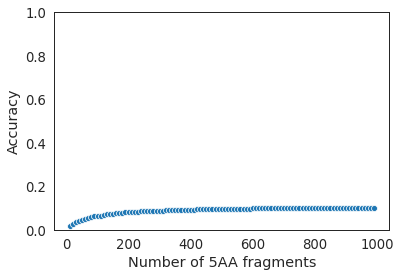

In [3]:
ax = sns.lineplot(data=fiveaa_frag, x='Fragments (5AA length)', y='Accuracy', marker='o', \
                 markersize=6, lw=2.5,)
ax.set_ylim(0, 1);
ax.set_xlabel('Number of 5AA fragments')
ax.set_ylabel('Accuracy');

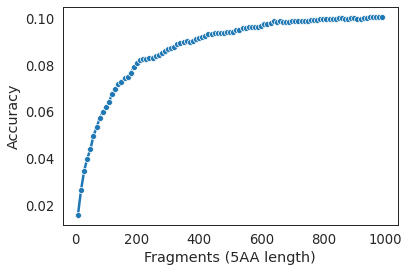

In [31]:
ax = sns.lineplot(data=fiveaa_frag, x='Fragments (5AA length)', y='Accuracy', marker='o', \
                 markersize=6, lw=2.5, )
# ax.set_ylim(0, 1);
# ax.set_xlabel('Number of 5AA fragments')
# ax.set_ylabel('Accuracy');

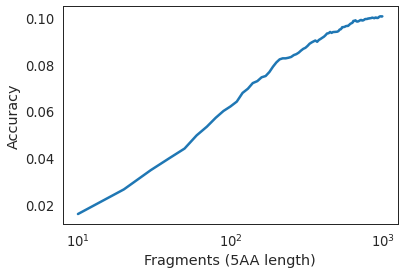

In [32]:
# plt.figure(figsize=(15, 4))
ax = sns.lineplot(data=fiveaa_frag[0:], x='Fragments (5AA length)', y='Accuracy', marker='o', \
                 markersize=0, lw=2.5, )
ax.set_xscale('log');
# ax.set_ylim(0, 1);
# ax.set_xlabel('Number of 5AA fragments')
# ax.set_ylabel('Accuracy');

In [78]:
all_results[(all_results['Type'] == '5 AA') & (all_results['max_prob'] == 0.9)]

,known aa,max_prob,identified_frac,Type
5,ACDEFGHIKLMNPQRSTVWY,0.9,0.015856,5 AA


In [82]:
(0.061939-0.015856)/0.015856

2.9063446014127146